In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

from __future__ import print_function, \
    division, \
    absolute_import

import os

import sep
import h5py

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from astropy.io import fits
from astropy.modeling import models, fitting

#---------------------------------------------------------------------------#
# User imports
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap
from kungpao.utils import seg_remove_cen_obj

# For Kungpao
x_images = '/Users/song/iraf/bin.macosx/x_images.e'
x_ttools = '/Users/song/iraf/extern/tables/bin.macosx/x_ttools.e'
x_isophote = '/Users/song/iraf/extern/stsdas/bin.macosx/x_isophote.e'
#---------------------------------------------------------------------------#

from skimage import exposure
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from skimage.filters import rank

from pymultiscale import starlet

#---------------------------------------------------------------------------#
# About the Colormaps
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = random_cmap(ncolors=512, background_color=u'white')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
from pyraf import iraf

iraf.tables()
iraf.stsdas()
iraf.analysis()
iraf.isophote()

iraf.unlearn('ellipse')
iraf.unlearn('bmodel')



      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |    
      |                  TABLES Version 3.17                       |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |    
      |                   STSDAS Version 3.17                      |
      |                   

In [3]:
def load_pkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None
    
    
def save_to_fits(image, name, header=None):
    """
    Save a 2-D array as fits image.
    """
    hdu = fits.PrimaryHDU(image)
    if header is not None:
        hdu.header = header
    hdu.writeto(name, overwrite=True)
    
    return


def show_illustris(img_cen, img_sat, img_icl, img_all):
    """
    Show the images of Illustris simulated galaxy.
    """
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        top=1.0, right=1.0, 
                        left=0.0, bottom=0.0)

    ax1 = plt.subplot(2, 2, 1)
    ax1 = display_single(img_all, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax2 = plt.subplot(2, 2, 2)
    ax2 = display_single(img_cen, ax=ax2, 
                         contrast=0.10,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax3 = plt.subplot(2, 2, 3)
    ax3 = display_single(img_sat, ax=ax3, 
                         contrast=0.12,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax4 = plt.subplot(2, 2, 4)
    ax4 = display_single(img_icl, ax=ax4, 
                         contrast=0.01,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)
    
    return fig

In [4]:
hscAvgProf0 = load_pkl("hscAvgProf0.pkl")
hscAvgProf1 = load_pkl("hscAvgProf1.pkl")
hscAvgProf2 = load_pkl("hscAvgProf2.pkl")

rm0_sl, rm0_ml, rm0_aml = hscAvgProf0['all'], hscAvgProf0['med'], hscAvgProf0['avg']
rm1_sl, rm1_ml, rm1_aml = hscAvgProf1['all'], hscAvgProf1['med'], hscAvgProf1['avg']
rm2_sl, rm2_ml, rm2_aml = hscAvgProf2['all'], hscAvgProf2['med'], hscAvgProf2['avg']

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)

# These are the median stellar mass density profiles for HSC galaxies at 0.3 < z < 0.5
# in three mass bins
# rm0 : 11.4 < logM_100kpc < 11.6 
# rm1 : 11.6 < logM_100kpc < 11.8 
# rm2 : 11.8 < logM_100kpc < 12.0 
# They are on a common radius array, and we use (r ** 0.25) as radius

# Load the Illustris stellar mass maps

In [5]:
illustris_file = 'galaxies_star_maps.hdf5'

# Load general simulation and galaxy properties
f = h5py.File(illustris_file, 'r')
snap_a = f.attrs['snap_a']
n_galaxies = len(f['cat_sh_id'])
sh_idx = np.array(f['cat_sh_id'])
grp_idx = np.array(f['cat_grp_id'])
cat_is_primary = np.array(f['cat_grp_is_primary'])
cat_sh_mstar = np.array(f['cat_sh_mstar'])
cat_sh_pos_bound = np.array(f['cat_sh_pos_bound'])
cat_sh_halfmrad_stars = np.array(f['cat_sh_halfmrad_stars'])

map_stars = np.array(f['map_stars'])
map_size = f['map_stars_size'].value
n_pixels = f['map_stars_npixel'].value
f.close()

In [6]:
# 10 galaxies, 3 maps (galaxy, surrounding, diffuse), 
#  3 projections (xy, xz, yz), 200 x 200 images
#  1 pixel = 3 kpc
map_stars.shape

pixel_scale = 3.0 # kpc / pixel

# Use Galaxy 1 Projection xy as example

12.5205 12.4234123714


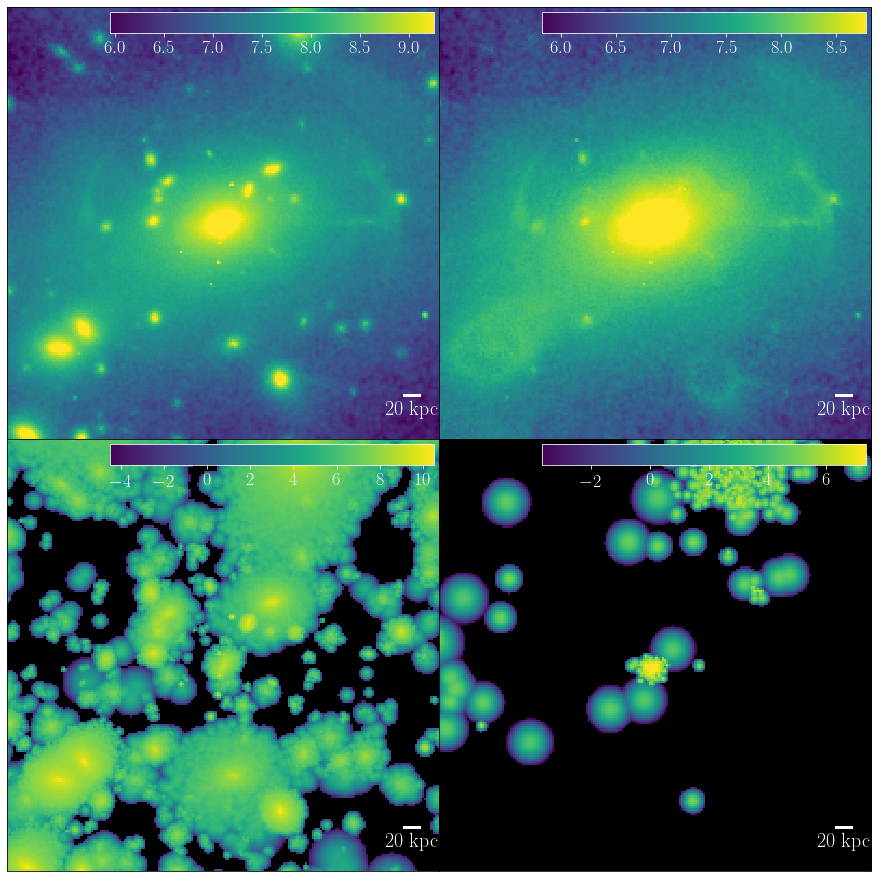

In [25]:
img_cen = map_stars[0, 0, 1] * (pixel_scale ** 2) # Central 
img_sat = map_stars[0, 1, 1] * (pixel_scale ** 2) # Satellites
img_icl = map_stars[0, 2, 1] * (pixel_scale ** 2) # Diffuse
img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse
# We convert the image into unit of stellar mass instead of mass density

log_mstar = np.log10(cat_sh_mstar[0])
log_mcen = np.log10(np.sum(img_cen))
print(log_mstar, log_mcen)

fits_prefix = 'illustris_1_xy'

save_to_fits(img_cen, fits_prefix + '_cen.fits')
save_to_fits(img_all, fits_prefix + '_all.fits')

_ = show_illustris(img_cen, img_sat, img_icl, img_all)


# Mean Sky / RMS Sky = 20727244.00000 / 7811238.00000


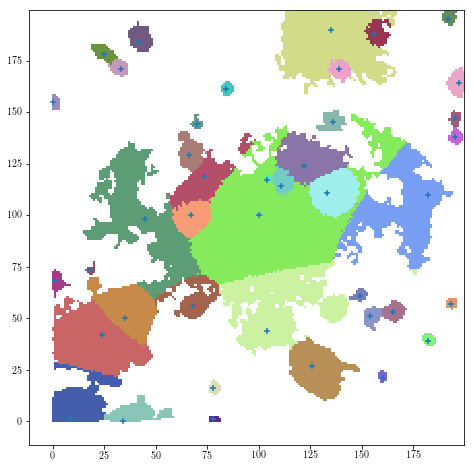

In [80]:
bkg_all = sep.Background(img_all, 
                         bw=50, bh=50, 
                         fw=3, fh=3)
print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_all.globalback,
                                                  bkg_all.globalrms))

objs_all, seg_all = sep.extract(img_all - bkg_cen.back(), 
                                5.0,
                                err=bkg_cen.globalrms,
                                minarea=10, 
                                deblend_nthresh=48, 
                                deblend_cont=0.001,
                                segmentation_map=True)

seg_all_mask = (seg_all > 0)

plt.figure(figsize=(8, 8))
plt.imshow(seg_all, origin='lower', cmap=SEG_CMAP, 
           alpha=1.0)
plt.scatter(objs_all['xcpeak'], objs_all['ycpeak'], marker='+')

# Mean Sky : 23712603.46959


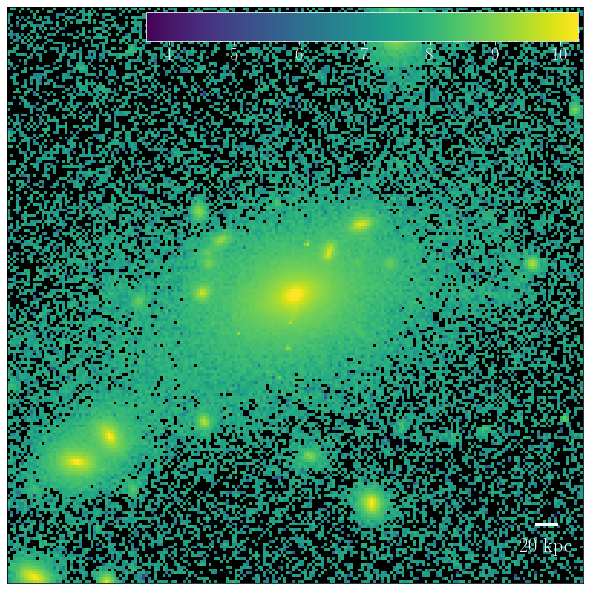

In [113]:
img_all_noise_1 = (img_all + 
                   np.random.normal(0.0, 4.0E7, img_all.shape))

bkg_noise_1 = np.nanmedian(img_all_noise_1[~seg_all_mask])
print("# Mean Sky : %10.5f" % (bkg_noise_1))

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_all_noise_1, 
                     ax=ax1,
                     contrast=0.05,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='log10',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Mean Sky : 23201098.70905


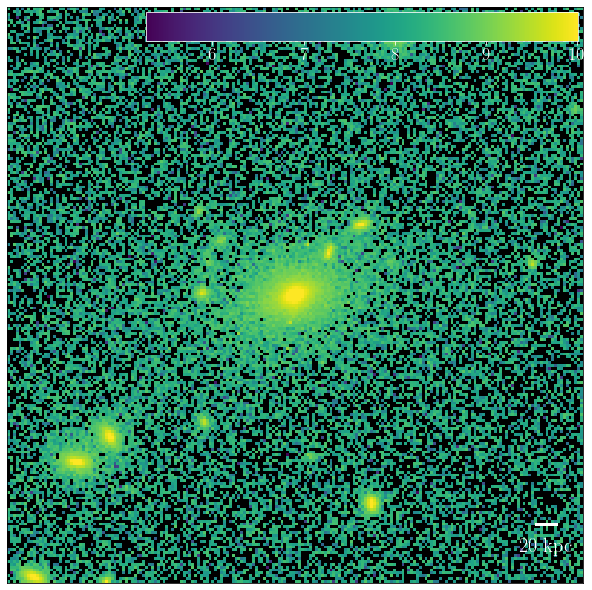

In [114]:
img_all_noise_2 = img_all + np.random.normal(0.0, 2.0E8, 
                                             img_all.shape)

bkg_noise_2 = np.nanmedian(img_all_noise_2[~seg_all_mask])
print("# Mean Sky : %10.5f" % (bkg_noise_2))

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_all_noise_2, 
                     ax=ax1,
                     contrast=0.05,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='log10',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

In [115]:
save_to_fits(img_all_noise_1 - bkg_noise_1 / 2.0, fits_prefix + '_all_noise_1.fits')
save_to_fits(img_all_noise_2 - bkg_noise_2 / 2.0, fits_prefix + '_all_noise_2.fits')

In [8]:
galX = 100.0 
galY = 100.0
galQ = 0.68
galPA = -70.76 * np.pi / 180.0

pix = (3.0)

m10, _, _ = sep.sum_ellipse(img_cen, galX, galY, 
                            (10 / pix), (10 / pix) * galQ, galPA)
m100, _, _ = sep.sum_ellipse(img_cen, galX, galY, 
                             (100 / pix), (100 / pix) * galQ, galPA)

print(np.log10(m10), np.log10(m100))

11.5766098758 12.2149392735


## Step 0: Measure the profiles on the central only image

# Mean Sky / RMS Sky = 15031176.00000 / 2641315.50000
# Detect 1 objects
[ 99.58306406] [ 99.51233175]


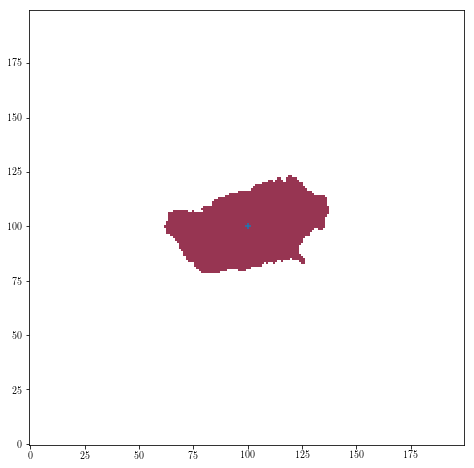

In [9]:
# First, do a simple detection and find the center of the central galaxy 

# Measure the background,
# Here on the image has no noise and has a lot of diffuse features
# so measure sky using a very small box (bw, bh values) helps us remove 
# a lot of the them, make the detection easier
# See: http://sep.readthedocs.io/en/v1.0.x/api/sep.Background.html#sep.Background 
# For more details
bkg_cen = sep.Background(img_cen, 
                         bw=10, bh=10, 
                         fw=5, fh=5)
print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_cen.globalback, bkg_cen.globalrms))

# Object detection after subtracting the background
# Since there is no noise on the image, we will just use the global RMS 
# from the background estimate as error
# Here, we use very high threshold, less aggressive deblending method to 
# make the detection focuses on the big object
objs_cen, seg_cen = sep.extract(img_cen - bkg_cen.back(), 
                                20.0,
                                err=bkg_cen.globalrms,
                                minarea=1000, 
                                deblend_nthresh=24, 
                                deblend_cont=0.1,
                                segmentation_map=True)

# And this is how you turn the segmentation image into a mask
# You can remove certain object from the segmentation map first
seg_mask = (seg_cen > 0)
print("# Detect %d objects" % len(objs_cen))

plt.figure(figsize=(8, 8))
plt.imshow(seg_cen, origin='lower', cmap=SEG_CMAP, 
           alpha=1.0)
plt.scatter(objs_cen['xcpeak'], objs_cen['ycpeak'], marker='+')

print(objs_cen['x'], objs_cen['y'])

In [46]:
# This is how we run surface brightness profile extraction 

# This process will generate some output files
# The outputs are:  [An Astropy table for the isophotes table] [Name of the output binary file]

# galSBP can fit the profiles in 4 ways:
# stage = 1 : leave the center and the shape (ellipticity and PA) of the isophote free
# stage = 2 : fix the center, leave only the shape (ellipticity and PA) of the isophote free
# stage = 3 : fix the geometry of the isophote, extract the profile
# stage = 4 : extract the profile using a pre-defined profile (using a out)

# For now, you need the following parameters:
# galX, galY: central coordinate (initial values or fixed at these values)
# galQ, galPA: axis ratio, position angle (degree) (initial values or fixed at these values)
# iniSma [pix]: stars the fitting at this radius 
# maxSma [pix]: maximum radius for profile extraction
# ellipStep: step size for the profile, smaller value means finer profile


# Free center and geometry
iso_cen_1, iso_cen_1_bin = galSBP.galSBP('illustris_1_xy_cen.fits', 
                                         galX=objs_cen[0]['x'], 
                                         galY=objs_cen[0]['y'], 
                                         galQ=(objs_cen[0]['b'] / objs_cen[0]['a']), 
                                         galPA=(objs_cen[0]['theta'] * 180.0 / np.pi), 
                                         maxSma=900, 
                                         iniSma=4.0, 
                                         harmonics='1 2 3 4',
                                         stage=1, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=True,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_cen_1_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_1['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  99.5830640558 99.5123317515
###      galR :  20.0
###      iniSma, maxSma :  10.0 900
###      Stage :  1
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen.fits
###      Input Image   : temp_7GQDI.fits
###      Output Binary : illustris_1_xy_cen_ellip_1.bin
----------------------------------------------------------------------------------------------------
-----------

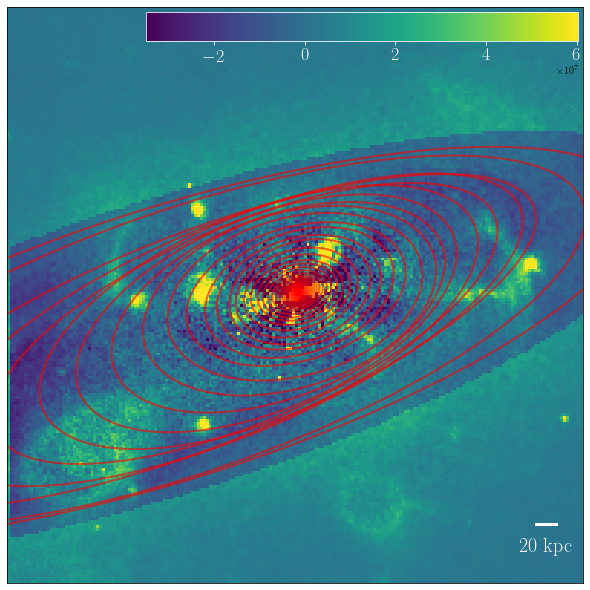

In [47]:
# Here, we use the stsdas.isophote.analysis.bmodel function to reconstruct 
# a 2-D model using the isophote information 
# So that we can subtract it from the original image, and see how well it does.

try: 
    os.remove(fits_prefix + '_cen_ellip_1.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen.fits', 
            table=iso_cen_1_bin,
            output=fits_prefix + '_cen_ellip_1.fits',
            minsma=0.0,
            highar='no')

img_cen_ellip_1 = fits.open(fits_prefix + '_cen_ellip_1.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen - img_cen_ellip_1, 
                     ax=ax1,
                     contrast=0.25,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_1_ellip = galSBP.convIso2Ell(iso_cen_1)
for ii, e in enumerate(iso_cen_1_ellip):
    if (ii % 3 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

# Here, we can see the model becomes off-center quickly, and it reveals many 
# diffuse features underneath. 

In [49]:
img_cen_norm = ((img_cen - np.min(img_cen) + 1.0) / 
                (np.max(img_cen) - np.min(img_cen)))

img_wt = starlet.starlet_transform(np.log10(img_cen_norm), 
                                   num_bands=5, 
                                   gen2=True)

len(img_wt)

6

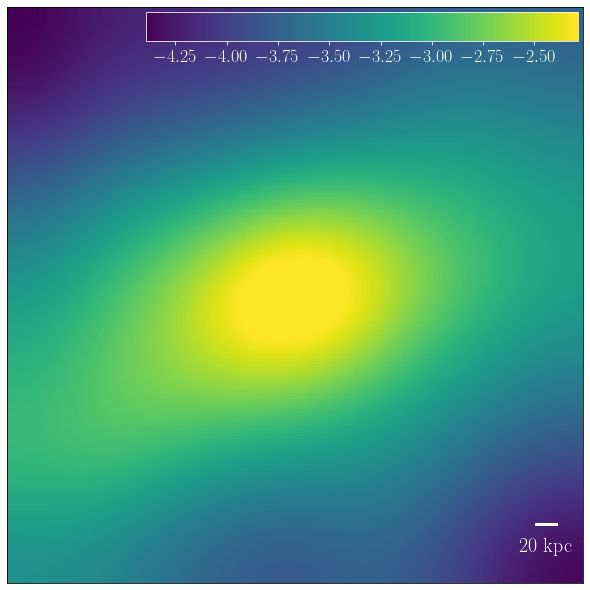

In [55]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_wt[5], 
                     ax=ax1,
                     contrast=0.25,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

Text(0.5,0,u'$\\mathrm{SMA}$')

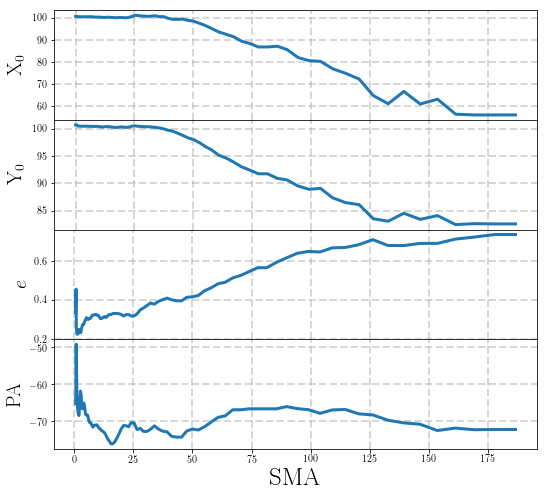

In [48]:
# Normally it is better to also check the profiles for geometry 

# Here you can see the central location changes with radius dramatically, 
# that tells you the image is asymmetric....which unfortunately makes the 
# profile extraction harder. 

fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(4, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot(iso_cen_1['sma'], iso_cen_1['x0'], linewidth=3.0)
ax1.set_ylabel(r'$\mathrm{X}_0$', fontsize=20)

ax2 = plt.subplot(4, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot(iso_cen_1['sma'], iso_cen_1['y0'], linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Y}_0$', fontsize=20)

ax3 = plt.subplot(4, 1, 3)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax3.plot(iso_cen_1['sma'], iso_cen_1['ell'], linewidth=3.0)
ax3.set_ylabel(r'$e$', fontsize=20)

ax4 = plt.subplot(4, 1, 4)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax4.plot(iso_cen_1['sma'], iso_cen_1['pa'], linewidth=3.0)
ax4.set_ylabel(r'$\mathrm{PA}$', fontsize=20)
ax4.set_xlabel(r'$\mathrm{SMA}$', fontsize=25)

In [51]:
# Now, let's fixe the center, and let the geometry to be free

iso_cen_2, iso_cen_2_bin = galSBP.galSBP('illustris_1_xy_cen.fits', 
                                         galX=100.5, 
                                         galY=100.5, 
                                         galQ=0.6, 
                                         galPA=-50.0, 
                                         maxSma=450, 
                                         iniSma=10.0, 
                                         stage=2, 
                                         intMode='median', 
                                         ellipStep=0.10,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_cen_2_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_2['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.5 100.5
###      galR :  20.0
###      iniSma, maxSma :  10.0 450
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen.fits
###      Input Image   : temp_R2GJF.fits
###      Output Binary : illustris_1_xy_cen_ellip_2.bin
----------------------------------------------------------------------------------------------------
----------------------------

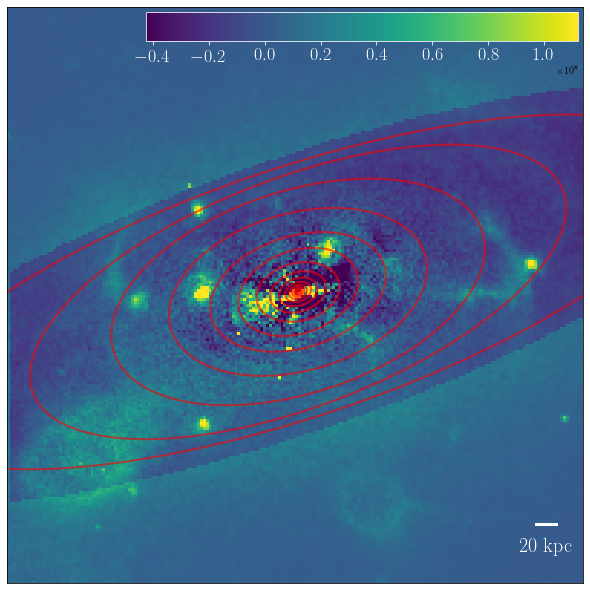

In [52]:
try: 
    os.remove(fits_prefix + '_cen_ellip_2.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen.fits', 
            table=iso_cen_2_bin,
            output=fits_prefix + '_cen_ellip_2.fits',
            minsma=0.0,
            highar='no')

img_cen_ellip_2 = fits.open(fits_prefix + '_cen_ellip_2.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen - img_cen_ellip_2, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_2_ellip = galSBP.convIso2Ell(iso_cen_2)
for ii, e in enumerate(iso_cen_2_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

# It seems that this galaxy is still not relaxed, and the central region is 
# highly asymmetric...

# You can try to change the central location, or the initial values of the parameters
# the situation is the same...tough case

Text(0.5,0,u'$\\mathrm{SMA}$')

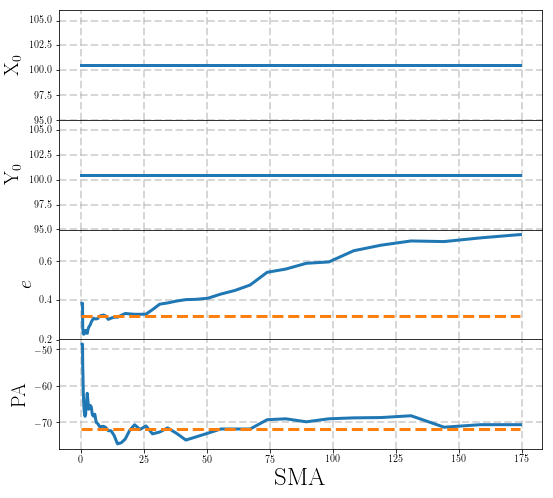

In [53]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(4, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot(iso_cen_2['sma'], iso_cen_2['x0'], linewidth=3.0)
ax1.set_ylabel(r'$\mathrm{X}_0$', fontsize=20)

ax2 = plt.subplot(4, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot(iso_cen_2['sma'], iso_cen_2['y0'], linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Y}_0$', fontsize=20)

ax3 = plt.subplot(4, 1, 3)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax3.plot(iso_cen_2['sma'], iso_cen_2['ell'], linewidth=3.0)
ax3.plot(iso_cen_2['sma'], (1.0 - iso_cen_2['avg_q']), 
         linestyle='--', linewidth=3.0)
ax3.set_ylabel(r'$e$', fontsize=20)

ax4 = plt.subplot(4, 1, 4)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax4.plot(iso_cen_2['sma'], iso_cen_2['pa'], linewidth=3.0)
ax4.set_ylabel(r'$\mathrm{PA}$', fontsize=20)
ax4.plot(iso_cen_2['sma'], iso_cen_2['avg_pa'],
         linestyle='--', linewidth=3.0)
ax4.set_xlabel(r'$\mathrm{SMA}$', fontsize=25)

Text(0.5,0,u'$\\mathrm{SMA/Pixel}^{1/4}$')

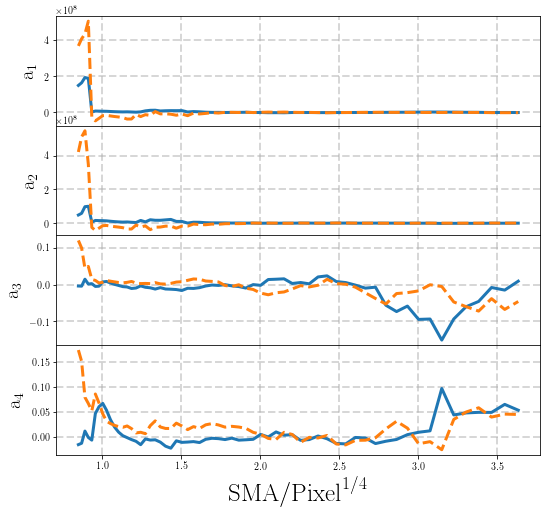

In [54]:
# When fitting the isophotes, we can add Fourier components to make it more flexible
# Here we can show the normalized amplitudes of the first four Fourier components. 

# Here, the bumpy features for A1 and A2 reflect the asymmetric feature.
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(4, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a1'], linewidth=3.0)
ax1.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b1'], linewidth=3.0, linestyle='--')
ax1.set_ylabel(r'$\mathrm{a}_1$', fontsize=20)

ax2 = plt.subplot(4, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a2'], linewidth=3.0)
ax2.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b2'], linewidth=3.0, linestyle='--')
ax2.set_ylabel(r'$\mathrm{a}_2$', fontsize=20)

ax3 = plt.subplot(4, 1, 3)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax3.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a3'], linewidth=3.0)
ax3.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b3'], linewidth=3.0, linestyle='--')
ax3.set_ylabel(r'$\mathrm{a}_3$', fontsize=20)

ax4 = plt.subplot(4, 1, 4)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax4.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a4'], linewidth=3.0)
ax4.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b4'], linewidth=3.0, linestyle='--')
ax4.set_ylabel(r'$\mathrm{a}_4$', fontsize=20)
ax4.set_xlabel(r'$\mathrm{SMA/Pixel}^{1/4}$', fontsize=25)

In [55]:
# Now, let's fix everything

pix = 3.0
iso_cen_3, iso_cen_3_bin = galSBP.galSBP('illustris_1_xy_cen.fits', 
                                         galX=100.5, 
                                         galY=100.5, 
                                         galQ=iso_cen_2['avg_q'][0], 
                                         galPA=iso_cen_2['avg_pa'][0], 
                                         maxSma=500, 
                                         iniSma=40.0, 
                                         stage=3, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=pix, 
                                         zpPhoto=0.0,
                                         harmonics='1 2',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_cen_3_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_3['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.5 100.5
###      galR :  20.0
###      iniSma, maxSma :  40.0 500
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen.fits
###      Input Image   : temp_PHERZ.fits
###      Output Binary : illustris_1_xy_cen_ellip_3.bin
----------------------------------------------------------------------------------------------------
---------------------------

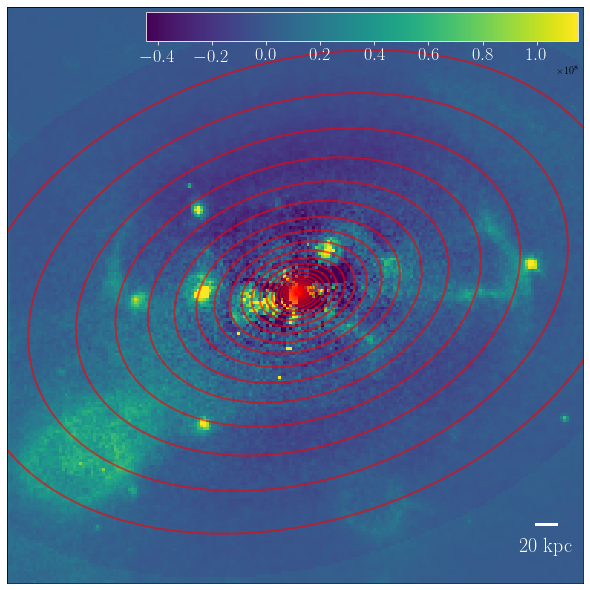

In [56]:
try: 
    os.remove(fits_prefix + '_cen_ellip_3.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen.fits', 
            table=iso_cen_3_bin,
            output=fits_prefix + '_cen_ellip_3.fits',
            minsma=0.0,
            highar='no')

img_cen_ellip_3 = fits.open(fits_prefix + '_cen_ellip_3.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen - img_cen_ellip_3, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_3_ellip = galSBP.convIso2Ell(iso_cen_3)
for ii, e in enumerate(iso_cen_3_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10


(1.0, 4.5)

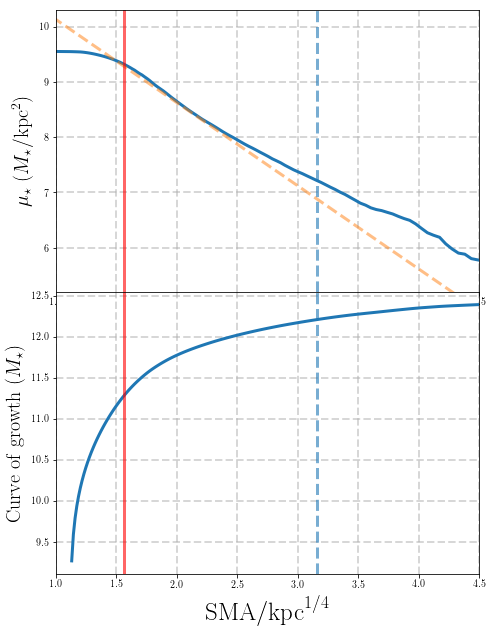

In [57]:
# Here is the 1-D mass density profile and the curve-of-growth of mass 

# I label the 6.0 kpc (twice the pixel size, not resolved within) and 100 kpc radius
fig = plt.figure(figsize=(7, 9))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)

# Overplot a de Vaucouleurs plot with Re=24 kpc
dev = models.Sersic1D(amplitude=np.median(iso_cen_3['intens'] / 9), 
                      r_eff=8, n=4.0)
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['intens'] / 9.0), linewidth=3.0)
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(dev(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.set_xlim(1.0, 4.5)
ax1.set_ylim(5.2, 10.3)

ax2 = plt.subplot(2, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['growth_ori']), linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', fontsize=20)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax2.set_xlim(1.0, 4.5)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10


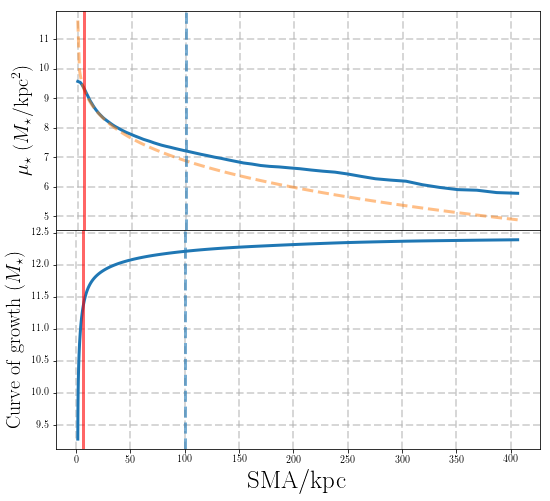

In [58]:
# And the difference becomes much more obvious when the X-axis is linear 

fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)

# Overplot a de Vaucouleurs plot with Re=24 kpc
dev = models.Sersic1D(amplitude=np.median(iso_cen_3['intens'] / 9), 
                      r_eff=8, n=4.0)
ax1.plot((iso_cen_3['sma'] * 3.0), 
         np.log10(iso_cen_3['intens'] / 9.0), linewidth=3.0)
ax1.plot((iso_cen_3['sma'] * 3.0), 
         np.log10(dev(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
#ax1.set_xlim(1.0, 4.5)

ax2 = plt.subplot(2, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot((iso_cen_3['sma'] * 3.0), 
         np.log10(iso_cen_3['growth_ori']), linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', fontsize=20)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)
ax2.axvline(100.0, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
#ax2.set_xlim(1.0, 4.5)

In [24]:
fitter = fitting.LevMarLSQFitter()
r_mask = (iso_cen_3['sma'] * 3.0 > 6.0)
xx = iso_cen_3['sma'][r_mask]
yy = iso_cen_3['intens'][r_mask] / 9.0

# Let try to fit a Sersic function
ser1_init = models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 9.0), 
                            r_eff=6.5, n=6.0)
ser1_fit = fitter(ser1_init, xx, yy)
print("# 1-Sersic model:")
print(ser1_fit.r_eff * 3.0, ser1_fit.n)

# Let try to fit 2-Sersic functions then
ser2_init = models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 8.0), 
                            r_eff=2.5, n=3.0) + \
            models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 12.0), 
                            r_eff=20.5, n=2.0)
ser2_fit = fitter(ser2_init, xx, yy)
print("\n# 2-Sersic model:")
print(ser2_fit.r_eff_0 * 3.0, ser2_fit.n_0)
print(ser2_fit.r_eff_1 * 3.0, ser2_fit.n_1)

# Let try to fit 3-Sersic functions then
ser3_init = models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 6.0), 
                            r_eff=2.5, n=2.0) + \
            models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 10.0), 
                            r_eff=12.5, n=1.5) + \
            models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 15.0), 
                            r_eff=25.5, n=1.0)
ser3_fit = fitter(ser3_init, xx, yy)
print("\n# 3-Sersic model:")
print(ser3_fit.r_eff_0 * 3.0, ser3_fit.n_0)
print(ser3_fit.r_eff_1 * 3.0, ser3_fit.n_1)
print(ser3_fit.r_eff_2 * 3.0, ser3_fit.n_2)

# 1-Sersic model:
17.4413221353 Parameter('n', value=2.5149628639)

# 2-Sersic model:
7.5979879325 Parameter('n_0', value=0.614318151451)
37.31075924 Parameter('n_1', value=2.40853570738)

# 3-Sersic model:
7.53932893849 Parameter('n_0', value=0.575539784754)
33.8400513909 Parameter('n_1', value=2.31607122388)
4.48402709022 Parameter('n_2', value=1.21877403452)


/usr/local/lib/python2.7/site-packages/astropy/modeling/functional_models.py:765: RuntimeWarning: invalid value encountered in power
  -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1)))


(1.0, 4.5)

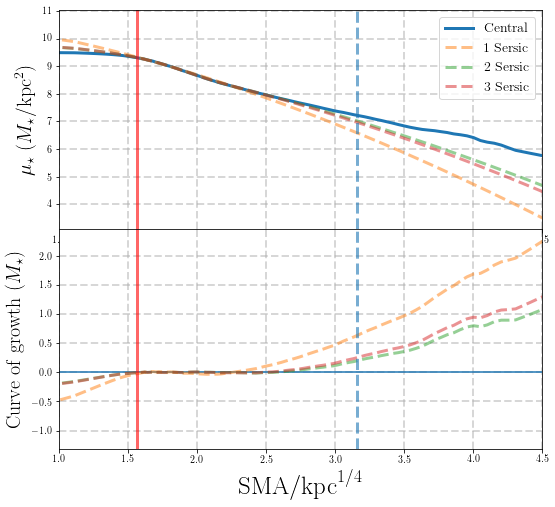

In [25]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['intens'] / 9.0), linewidth=3.0,
         label=r'$\mathrm{Central}$')
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(ser1_fit(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{1\ Sersic}$')
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(ser2_fit(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{2\ Sersic}$')
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(ser3_fit(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{3\ Sersic}$')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.set_xlim(1.0, 4.5)
ax1.legend(fontsize=14)

ax2 = plt.subplot(2, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot([0.0, 4.5], [0.0, 0.0])
ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         (np.log10(iso_cen_3['intens'] / 9.0) - 
          np.log10(ser1_fit(iso_cen_3['sma']))), 
         linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{1\ Sersic}$')
ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         (np.log10(iso_cen_3['intens'] / 9.0) - 
          np.log10(ser2_fit(iso_cen_3['sma']))), 
         linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{2\ Sersic}$')
ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         (np.log10(iso_cen_3['intens'] / 9.0) - 
          np.log10(ser3_fit(iso_cen_3['sma']))), 
         linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{3\ Sersic}$')
ax2.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', fontsize=20)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax2.set_xlim(1.0, 4.5)

# Test about mask

In [90]:
# Now, let's fixe the center, and let the geometry to be free

iso_all_2, iso_all_2_bin = galSBP.galSBP('illustris_1_xy_all.fits', 
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=0.6, 
                                         galPA=-50.0, 
                                         maxSma=300, 
                                         iniSma=10.0, 
                                         stage=2, 
                                         intMode='median', 
                                         ellipStep=0.10,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_all_2_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_all_2['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 300
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_all.fits
###      Input Image   : temp_YREYY.fits
###      Output Binary : illustris_1_xy_all_ellip_2.bin
----------------------------------------------------------------------------------------------------
----------------------------

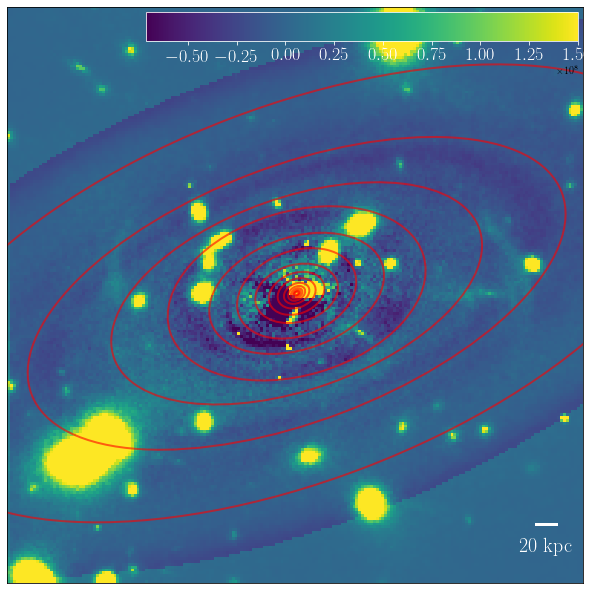

In [91]:
try: 
    os.remove(fits_prefix + '_all_ellip_2.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_all.fits', 
            table=iso_all_2_bin,
            output=fits_prefix + '_all_ellip_2.fits',
            minsma=0.0,
            highar='no')

img_all_ellip_2 = fits.open(fits_prefix + '_all_ellip_2.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_all - img_all_ellip_2, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_all_2_ellip = galSBP.convIso2Ell(iso_all_2)
for ii, e in enumerate(iso_all_2_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

# It seems that this galaxy is still not relaxed, and the alltral region is 
# highly asymmetric...

# You can try to change the alltral location, or the initial values of the parameters
# the situation is the same...tough case

In [40]:
# Now, let's fix everything

iso_all_3, iso_all_3_bin = galSBP.galSBP('illustris_1_xy_all.fits', 
                                         inEllip='illustris_1_xy_cen_ellip_3.bin',
                                         galX=100.5, 
                                         galY=100.5, 
                                         galQ=0.68, 
                                         galPA=-70.76, 
                                         maxSma=350, 
                                         iniSma=50.0, 
                                         stage=4, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_all_3_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_all_3['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.5 100.5
###      galR :  20.0
###      iniSma, maxSma :  50.0 350
###      Stage :  4
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_all.fits
###      Input Image   : temp_K8X7Y.fits
###      Output Binary : illustris_1_xy_all_ellip_4.bin
----------------------------------------------------------------------------------------------------
---------------------------

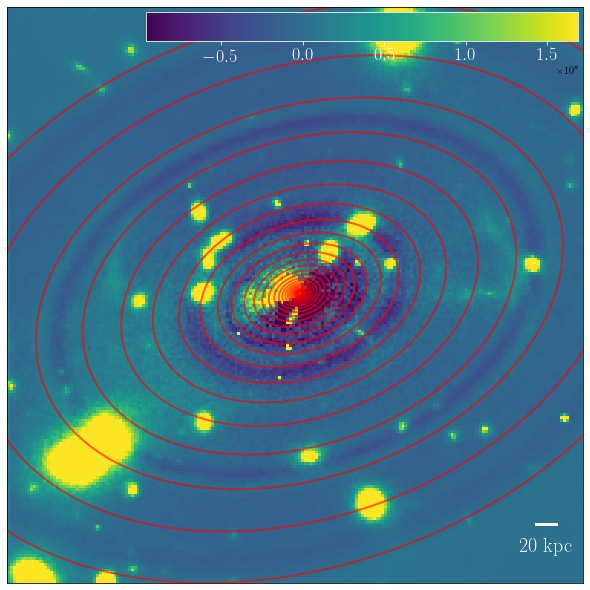

In [137]:
try: 
    os.remove(fits_prefix + '_all_ellip_4.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_all.fits', 
            table=iso_all_3_bin,
            output=fits_prefix + '_all_ellip_4.fits',
            minsma=0.0,
            highar='no')

img_all_ellip_3 = fits.open(fits_prefix + '_all_ellip_4.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_all - img_all_ellip_3, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_all_3_ellip = galSBP.convIso2Ell(iso_all_3)
for ii, e in enumerate(iso_all_3_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

# Detect 39 objects


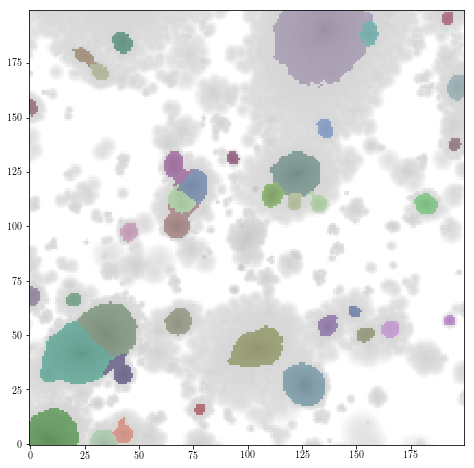

In [138]:
objs_sat, seg_sat_1 = sep.extract(img_sat, 
                                  2.0,
                                  err=bkg_cen.globalrms,
                                  minarea=20, 
                                  deblend_nthresh=48, 
                                  deblend_cont=0.001,
                                  segmentation_map=True)

seg_sat_1 = seg_remove_cen_obj(seg_sat_1)

seg_mask_1 = (seg_sat_1 > 0)
print("# Detect %d objects" % len(objs_sat))

plt.figure(figsize=(8, 8))
plt.imshow(np.arcsinh(img_sat), origin='lower', 
           cmap='gist_gray_r', alpha=0.5)
plt.imshow(seg_sat_1, origin='lower', cmap=SEG_CMAP, 
           alpha=0.5)

save_to_fits(seg_mask_1.astype(np.int16), 
             fits_prefix + '_sat_msk_1.fits')

In [96]:
# Now, let's fixe the center, and let the geometry to be free

iso_all_4, iso_all_4_bin = galSBP.galSBP('illustris_1_xy_all.fits', 
                                         mask=fits_prefix + '_sat_msk_1.fits',
                                         plMask=True,
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=0.6, 
                                         galPA=-50.0, 
                                         maxSma=350, 
                                         iniSma=10.0, 
                                         stage=2, 
                                         intMode='median', 
                                         ellipStep=0.10,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_all_4_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_all_4['mag_tot'][0] / -2.5))

illustris_1_xy_sat_msk_1.fits -> temp_EFW92.fits.pl
illustris_1_xy_sat_msk_1.fits -> temp_EFW92.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 350
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_all.fits
###      Input Image   : temp_EFW92.fits
###      Output Binary : illustris_1_xy_all_ellip_2.bin
------------------------------

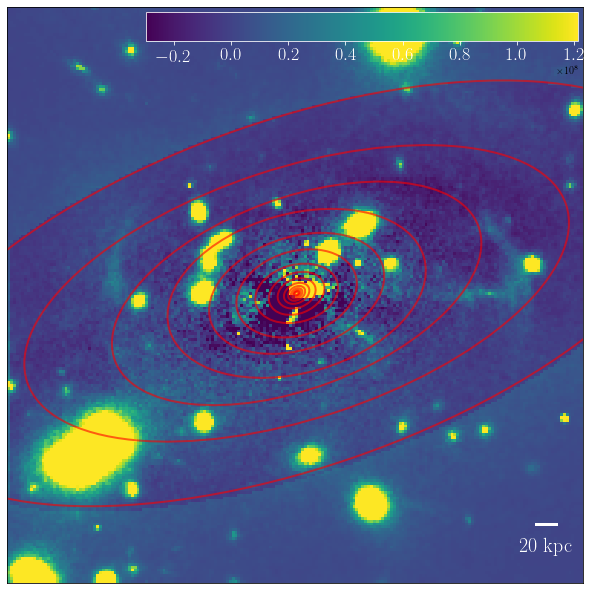

In [98]:
try: 
    os.remove(fits_prefix + '_all_ellip_2.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_all.fits', 
            table=iso_all_4_bin,
            output=fits_prefix + '_all_ellip_2.fits',
            minsma=0.0,
            highar='no')

img_all_ellip_4 = fits.open(fits_prefix + '_all_ellip_2.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_all - img_all_ellip_4, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_all_4_ellip = galSBP.convIso2Ell(iso_all_4)
for ii, e in enumerate(iso_all_4_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

# It seems that this galaxy is still not relaxed, and the alltral region is 
# highly asymmetric...

# You can try to change the alltral location, or the initial values of the parameters
# the situation is the same...tough case

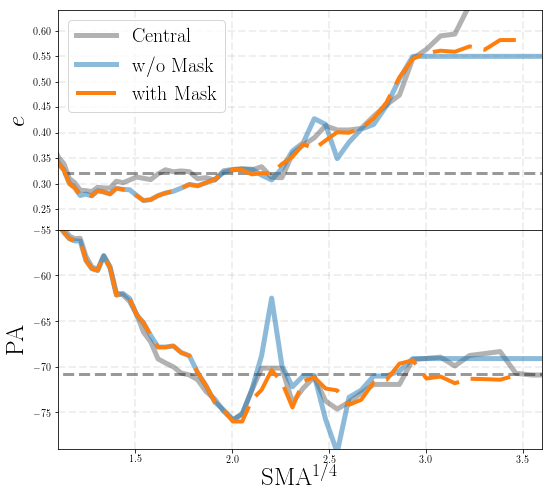

In [139]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax3 = plt.subplot(2, 1, 1)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.2)
ax3.set_ylabel(r'$e$', fontsize=25)

ax4 = plt.subplot(2, 1, 2)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.2)
ax4.set_ylabel(r'$\mathrm{PA}$', fontsize=25)
ax4.set_xlabel(r'$\mathrm{SMA^{1/4}}$', fontsize=25)

# Central only
ax3.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['ell'], 
         linewidth=5.0, c='k', alpha=0.3, 
         label=r'$\mathrm{Central}$')
ax4.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['pa'], 
         linewidth=5.0, c='k', alpha=0.3)

# Average
ax3.plot(iso_cen_2['sma'] ** 0.25, (1.0 - iso_cen_2['avg_q']), 
         linestyle='--', linewidth=3.0, 
         c='k', alpha=0.4, label='_no_label')
ax4.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['avg_pa'],
         linestyle='--', linewidth=3.0, 
         c='k', alpha=0.4)

# No mask 
ax3.plot(iso_all_2['sma'] ** 0.25, iso_all_2['ell'], 
         linewidth=5.0, alpha=0.5,
         label=r'$\mathrm{w/o\ Mask}$')
ax4.plot(iso_all_2['sma'] ** 0.25, iso_all_2['pa'], 
         linewidth=5.0, alpha=0.5)

# Small mask
ax3.plot(iso_all_4['sma'] ** 0.25, iso_all_4['ell'], 
         linewidth=4.0, linestyle='--', dashes=(10, 3), 
         label=r'$\mathrm{with\ Mask}$')
ax4.plot(iso_all_4['sma'] ** 0.25, iso_all_4['pa'], 
         linewidth=4.0, linestyle='--', dashes=(10, 3))

ax3.set_xlim(1.1, 3.6)
ax3.set_ylim(0.21, 0.64)

ax4.set_xlim(1.1, 3.6)
ax4.set_ylim(-79, -55)

ax3.legend(fontsize=20)


In [140]:
# Now, let's fixe the center, and let the geometry to be free

iso_all_5, iso_all_5_bin = galSBP.galSBP('illustris_1_xy_all.fits', 
                                         inEllip='illustris_1_xy_cen_ellip_3.bin',
                                         mask=fits_prefix + '_sat_msk_1.fits',
                                         plMask=True,
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=iso_all_2['avg_q'][0], 
                                         galPA=iso_all_2['avg_pa'][0], 
                                         iniSma=50.0, 
                                         maxSma=350, 
                                         stage=4, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_all_5_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_all_5['mag_tot'][0] / -2.5))

illustris_1_xy_sat_msk_1.fits -> temp_IKU6U.fits.pl
illustris_1_xy_sat_msk_1.fits -> temp_IKU6U.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 350
###      Stage :  4
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_all.fits
###      Input Image   : temp_IKU6U.fits
###      Output Binary : illustris_1_xy_all_ellip_4.bin
-----------------------------

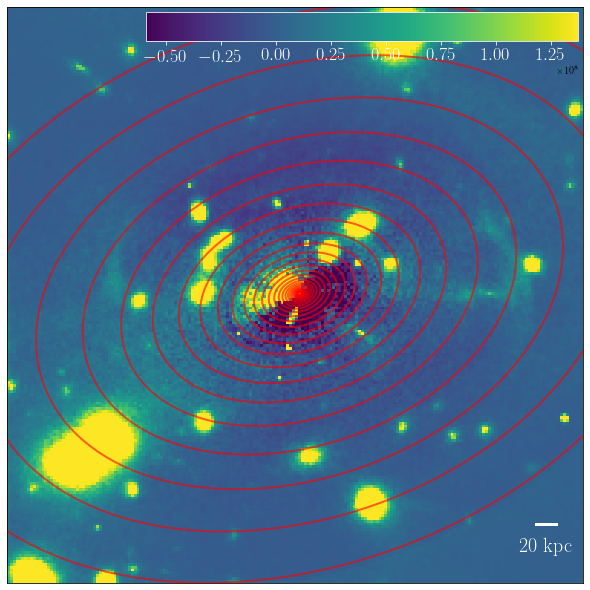

In [141]:
try: 
    os.remove(fits_prefix + '_all_ellip_3.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_all.fits', 
            table=iso_all_3_bin,
            output=fits_prefix + '_all_ellip_3.fits',
            minsma=0.0,
            highar='no')

img_all_ellip_5 = fits.open(fits_prefix + '_all_ellip_3.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_all - img_all_ellip_5, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_all_5_ellip = galSBP.convIso2Ell(iso_all_5)
for ii, e in enumerate(iso_all_5_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

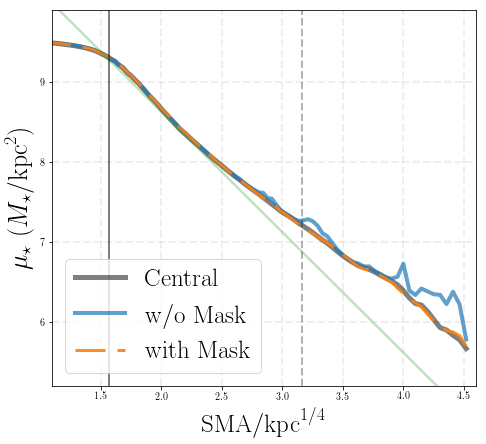

In [155]:
# Here is the 1-D mass density profile and the curve-of-growth of mass 

# I label the 6.0 kpc (twice the pixel size, not resolved within) and 100 kpc radius
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(1, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.2)

# Overplot a de Vaucouleurs plot with Re=24 kpc
dev = models.Sersic1D(amplitude=np.median(iso_cen_3['intens'] / 9), 
                      r_eff=8, n=4.0)

ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['intens'] / 9.0),
         linewidth=5.0, alpha=0.5, c='k',
         label=r'$\mathrm{Central}$')

ax1.plot((iso_all_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_all_3['intens'] / 9.0),
         linewidth=4.0, alpha=0.7,
         label=r'$\mathrm{w/o\ Mask}$')

ax1.plot((iso_all_5['sma'] * 3.0) ** 0.25, 
         np.log10(iso_all_5['intens'] / 9.0), 
         linewidth=3.0, alpha=0.9, 
         linestyle='--', dashes=(10, 4),
         label=r'$\mathrm{with\ Mask}$')

ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(dev(iso_cen_3['sma'])), 
         linewidth=2.5, alpha=0.3, 
         label='_no_label_')

ax1.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', 
               fontsize=25)
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', 
               fontsize=26)

ax1.axvline(100.0 ** 0.25, linestyle='--', 
            linewidth=2.0, alpha=0.3, c='k')
ax1.axvline(6.0 ** 0.25, linestyle='-', 
            linewidth=2.0, alpha=0.5, c='k')

ax1.set_xlim(1.1, 4.6)
ax1.set_ylim(5.2, 9.9)

ax1.legend(fontsize=25, loc=3)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


(10.5, 12.59)

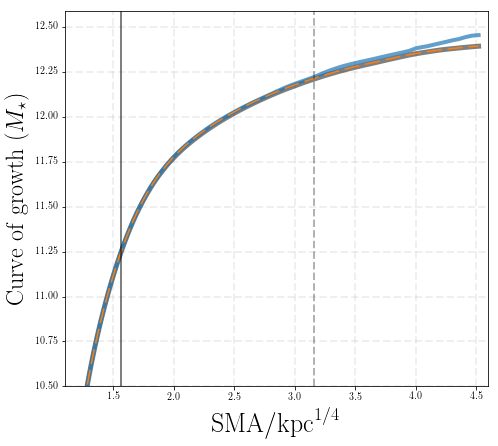

In [162]:
# I label the 6.0 kpc (twice the pixel size, not resolved within) and 100 kpc radius
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax2 = plt.subplot(1, 1, 1)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.2)

ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['growth_ori']), 
         linewidth=5.0, alpha=0.5, c='k')

ax2.plot((iso_all_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_all_3['growth_ori']),
         linewidth=4.0, alpha=0.7)
    
ax2.plot((iso_all_5['sma'] * 3.0) ** 0.25, 
         np.log10(iso_all_5['growth_ori']),
         linestyle='--', dashes=(10, 4))

ax2.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', 
               fontsize=24)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', 
               fontsize=26)

ax2.axvline(100.0 ** 0.25, linestyle='--', 
            linewidth=2.0, alpha=0.3, c='k')
ax2.axvline(6.0 ** 0.25, linestyle='-', 
            linewidth=2.0, alpha=0.5, c='k')

ax2.set_xlim(1.1, 4.6)
ax2.set_ylim(10.5, 12.59)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in subtract


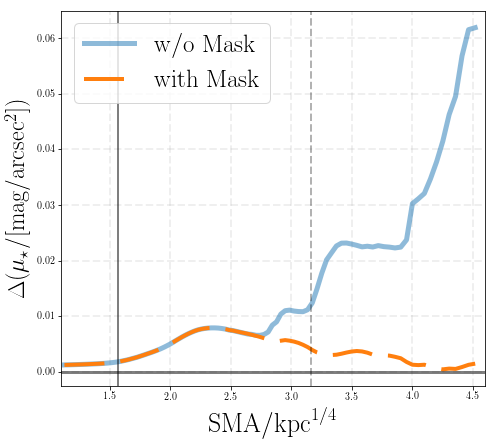

In [167]:
# I label the 6.0 kpc (twice the pixel size, not resolved within) and 100 kpc radius
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax2 = plt.subplot(1, 1, 1)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.2)

ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_all_3['growth_ori']) - np.log10(iso_cen_3['growth_ori']), 
         linewidth=5.0, alpha=0.5, label=r'$\mathrm{w/o\ Mask}$')

ax2.plot((iso_all_5['sma'] * 3.0) ** 0.25, 
         np.log10(iso_all_5['growth_ori']) - np.log10(iso_cen_3['growth_ori']),
         linewidth=4.0, linestyle='--', dashes=(10, 4), 
         label=r'$\mathrm{with\ Mask}$')

ax2.set_ylabel(r'$\Delta(\mu_{\star}/[\mathrm{mag}/\mathrm{arcsec}^2])$', 
               fontsize=24)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', 
               fontsize=26)

ax2.axvline(100.0 ** 0.25, linestyle='--', 
            linewidth=2.0, alpha=0.3, c='k')
ax2.axvline(6.0 ** 0.25, linestyle='-', 
            linewidth=2.0, alpha=0.5, c='k')

ax2.axhline(0.0, linestyle='-', 
            linewidth=3.0, alpha=0.5, c='k')

ax2.set_xlim(1.1, 4.6)
#ax2.set_ylim(10.5, 12.59)

ax2.legend(fontsize=25)

In [116]:
# Test noise added image

iso_all_6, iso_all_6_bin = galSBP.galSBP('illustris_1_xy_all_noise_1.fits', 
                                         mask=fits_prefix + '_sat_msk_1.fits',
                                         plMask=True,
                                         galX=100.5, 
                                         galY=100.5, 
                                         galQ=0.68, 
                                         galPA=-70.76, 
                                         iniSma=30.0, 
                                         maxSma=350, 
                                         stage=3, 
                                         intMode='mean', 
                                         ellipStep=0.1,
                                         pix=3.0, 
                                         harmonics='1 2 3 4',
                                         zpPhoto=0.0,
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_all_6_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_all_6['mag_tot'][0] / -2.5))

iso_all_7, iso_all_7_bin = galSBP.galSBP('illustris_1_xy_all_noise_2.fits', 
                                         mask=fits_prefix + '_sat_msk_1.fits',
                                         plMask=True,
                                         galX=100.5, 
                                         galY=100.5, 
                                         galQ=0.68, 
                                         galPA=-70.76, 
                                         iniSma=30.0, 
                                         maxSma=350, 
                                         stage=3, 
                                         intMode='mean', 
                                         ellipStep=0.1,
                                         pix=3.0, 
                                         harmonics='1 2 3 4',
                                         zpPhoto=0.0,
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_all_7_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_all_7['mag_tot'][0] / -2.5))

illustris_1_xy_sat_msk_1.fits -> temp_LFEM9.fits.pl
illustris_1_xy_sat_msk_1.fits -> temp_LFEM9.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  100.5 100.5
###      galR :  20.0
###      iniSma, maxSma :  30.0 350
###      Stage :  3
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_all_noise_1.fits
###      Input Image   : temp_LFEM9.fits
###      Output Binary : illustris_1_xy_all_noise_1_ellip_3.bin
--------------

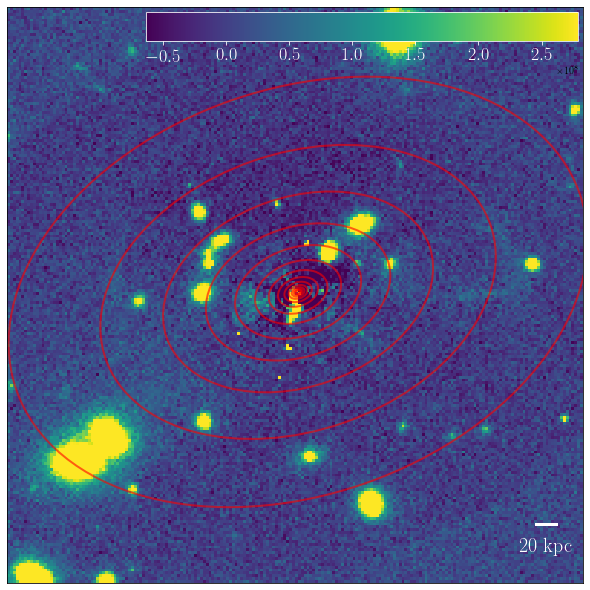

In [93]:
try: 
    os.remove(fits_prefix + '_all_ellip_6.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_all_noise_1.fits', 
            table=iso_all_6_bin,
            output=fits_prefix + '_all_ellip_6.fits',
            minsma=0.0,
            highar='no')

img_all_ellip_6 = fits.open(fits_prefix + '_all_ellip_6.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_all_noise_1 - img_all_ellip_6, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_all_6_ellip = galSBP.convIso2Ell(iso_all_6)
for ii, e in enumerate(iso_all_6_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

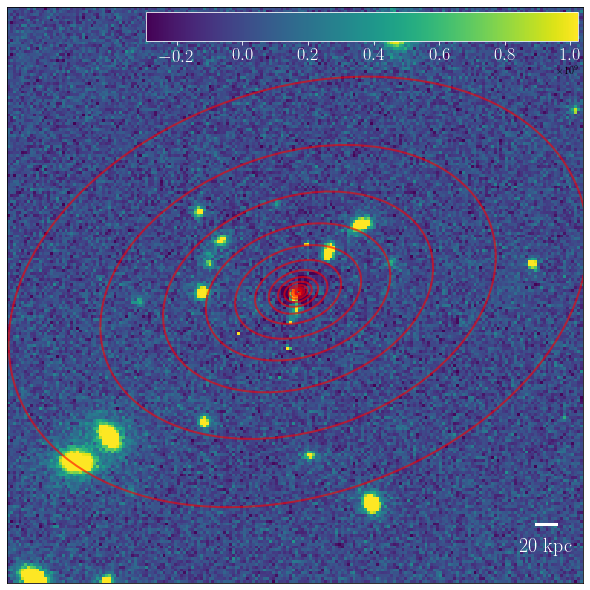

In [94]:
try: 
    os.remove(fits_prefix + '_all_ellip_7.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_all_noise_2.fits', 
            table=iso_all_7_bin,
            output=fits_prefix + '_all_ellip_7.fits',
            minsma=0.0,
            highar='no')

img_all_ellip_7 = fits.open(fits_prefix + '_all_ellip_7.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_all_noise_2 - img_all_ellip_7, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_all_7_ellip = galSBP.convIso2Ell(iso_all_7)
for ii, e in enumerate(iso_all_7_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

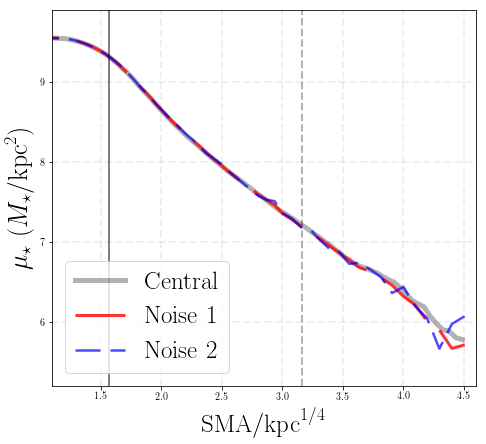

In [120]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(1, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.2)

ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['intens'] / 9.0),
         linewidth=5.0, alpha=0.3, c='k',
         label=r'$\mathrm{Central}$')

ax1.plot((iso_all_6['sma'] * 3.0) ** 0.25, 
         np.log10(iso_all_6['intens'] / 9.0), 
         linewidth=3.0, alpha=0.8, c='r',
         linestyle='--', dashes=(20, 6),
         label=r'$\mathrm{Noise\ 1}$')

ax1.plot((iso_all_7['sma'] * 3.0) ** 0.25, 
         np.log10(iso_all_7['intens'] / 9.0), 
         linewidth=2.5, alpha=0.7, c='b',
         linestyle='--', dashes=(10, 4),
         label=r'$\mathrm{Noise\ 2}$')

ax1.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', 
               fontsize=25)
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', 
               fontsize=26)

ax1.axvline(100.0 ** 0.25, linestyle='--', 
            linewidth=2.0, alpha=0.3, c='k')
ax1.axvline(6.0 ** 0.25, linestyle='-', 
            linewidth=2.0, alpha=0.5, c='k')

ax1.set_xlim(1.1, 4.6)
ax1.set_ylim(5.2, 9.9)

ax1.legend(fontsize=25, loc=3)

# Save for later ...

9.0


(0.9, 4.5)

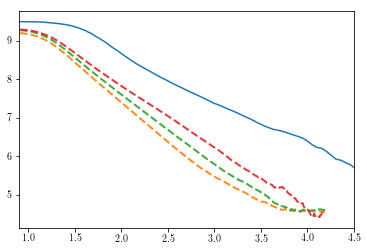

In [39]:
pix_size = 3.0  
scale_factor = 0.7
h_factor = 0.7

pix_phys = (pix_size)
pix_area = (pix_phys * pix_phys)
print(pix_area)

rad_phys = iso_cen_3['sma'] * pix_phys
sbp_phys = np.log10(iso_cen_3['intens'] / pix_area)

plt.plot(rad_phys ** 0.25, sbp_phys)

## Median profiles from HSC
plt.plot(RSMA_COMMON, rm0_aml[2], linestyle='--', linewidth=2.0, 
         alpha=0.9, zorder=8)
plt.plot(RSMA_COMMON, rm1_aml[2], linestyle='--', linewidth=2.0, 
         alpha=0.9, zorder=8)
plt.plot(RSMA_COMMON, rm2_aml[2], linestyle='--', linewidth=2.0, 
         alpha=0.9, zorder=8)

plt.xlim(0.9, 4.5)